# **Kenya Housing Value Details**

Among the worst hit sectors due to Covid-19 was the real estate. According to the data provided by the [Kenya Property Center](https://kenyapropertycentre.com/market-trends/average-prices), Nairobi tops the list of county with an average high of KSh 70,000 per month in rental houses followed by Mombasa and Kilifi with an average of KSh 40,000 per month. Based on towns, Lavington, Karen, an Westlands top the list with an average monthly rental charges of KSh 210K, KSh 150K, and 130K respectively. The dataset of interest is obtained [here](https://www.kaggle.com/datasets/iamasteriix/rental-apartments-in-kenya).

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set_style('whitegrid')
import pingouin
from scipy.stats import norm, t, levene
from statsmodels.stats import weightstats as stests

apt_rents = pd.read_csv('rent_apts.csv')
apt_rents.head()

,Agency,Neighborhood,Price,link,sq_mtrs,Bedrooms,Bathrooms
0,Buy Rent Shelters,"General Mathenge, Westlands","KSh 155,000",/listings/4-bedroom-apartment-for-rent-general...,4.0,4.0,4.0
1,Kenya Classic Homes,"Kilimani, Dagoretti North","KSh 100,000",/listings/3-bedroom-apartment-for-rent-kiliman...,300.0,3.0,4.0
2,Absolute Estate Agents,"Hatheru Rd,, Lavington, Dagoretti North","KSh 75,000",/listings/3-bedroom-apartment-for-rent-lavingt...,3.0,3.0,5.0
3,A1 Properties Limited,"Kilimani, Dagoretti North","KSh 135,000",/listings/3-bedroom-apartment-for-rent-kiliman...,227.0,3.0,4.0
4,Pmc Estates Limited,"Imara Daima, Embakasi","KSh 50,000",/listings/3-bedroom-apartment-for-rent-imara-d...,3.0,3.0,NaN


# **Data Cleaning & Selection** 

From the data, the variables of interest are `Neighborhood`, `Price`, House size (`sq_mtrs`), number of bedrooms (`bedrooms`)and `bathrooms`. However, before analysis, some cleaning is in order. As a starting point, only two variables will be considered$-$`Neighborhood` and `Price`. The remaining adjustments will be considered as analysis goes by.

In [2]:
apt_rents.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1848 entries, 0 to 1847
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Agency        1848 non-null   object 
 1   Neighborhood  1848 non-null   object 
 2   Price         1848 non-null   object 
 3   link          1848 non-null   object 
 4   sq_mtrs       1846 non-null   float64
 5   Bedrooms      1845 non-null   float64
 6   Bathrooms     1557 non-null   float64
dtypes: float64(3), object(4)
memory usage: 101.2+ KB


## Neighborhood to Region

The `Neighborhood` variable contains the location of these houses. 

- A look at these values shows that there are over 600 unique places. However, the interest is on specific locations.

In [3]:
len(apt_rents.Neighborhood.unique())

647

Here, we create a column `region`. This column will contain the constituency name with a few exceptions of places like 'Mombasa Rd' among others. Now out of 647 unique `Neighborhoods` there are only 37 unique neighborhoods stored in the column `region`. Note that whitespace is removed.

In [4]:
get_region = lambda x: x.rpartition(',')[-1]
remove_space = lambda x: x.strip()

apt_rents['region'] = apt_rents.Neighborhood\
                .apply(get_region)\
                .apply(remove_space)

print('number of regions:', len(apt_rents.region.unique()), '\n')
print(apt_rents.region.unique())

number of regions: 37 

['Westlands' 'Dagoretti North' 'Embakasi' 'Thika Road' 'Thindigua' 'Nyali'
 'Kiambaa' 'Kisauni' 'Dagoretti South' 'Kiambu Road' 'Roysambu' 'Kasarani'
 'Kajiado North' 'Athi River' 'Ngong' 'Kikuyu' 'Ruiru' 'Kisumu Central'
 'Kabete' 'Langata' 'Thika' 'Mombasa Road' 'Kisumu West' 'Thika East'
 'Kilifi South' 'Ngong Road' 'Kiambu Town' 'Eldoret North'
 'Kiambu Constituency' 'Starehe' 'Makadara' 'Kangundo' 'Mombasa CBD'
 'Milimani' 'Mvita' 'Muthaiga' 'Ruaraka']


## Rental Prices

The `Price` variables also need some adjustments to convert it from an `Object` data type to integer.

- To do this the comma and the `KSh` currency symbol are removed.

In [5]:
remove_character = lambda x: x.translate({ord(c): None for c in ",KSh"})

apt_rents['rental_price'] = apt_rents.Price\
        .apply(remove_character)\
        .astype('int64')

print(apt_rents.rental_price.head())
assert apt_rents.rental_price.dtype == 'int64'

0    155000
1    100000
2     75000
3    135000
4     50000
Name: rental_price, dtype: int64


## Data Selection

The variables `Agency` and `link` won't be of use in this analysis but they provide some useful information to buyers. 

- Onwards, the data for analysis is stored in `rental_aprt` DataFrame.

In [6]:
rental_aprt = apt_rents[['region', 'rental_price', 
                         'sq_mtrs', 'Bedrooms', 
                         'Bathrooms']]
print(rental_aprt.head())

            region  rental_price  sq_mtrs  Bedrooms  Bathrooms
0        Westlands        155000      4.0       4.0        4.0
1  Dagoretti North        100000    300.0       3.0        4.0
2  Dagoretti North         75000      3.0       3.0        5.0
3  Dagoretti North        135000    227.0       3.0        4.0
4         Embakasi         50000      3.0       3.0        NaN


## Further Selection

This analysis will be based on regions. Therefore, to use parametric analysis, each `region` should have about 30 entries across the variables. 

- Going by this assumptions, only 6 regions meet the requirement.

In [7]:
thirty_more = (rental_aprt.region.value_counts() >= 30).sum()
print(f'Count of regions with more than 30 entries: {thirty_more}')

Count of regions with more than 30 entries: 6


Therefore, sub-setting is in order. Here, a list that contains regions with 30 entries across the variables, `thirty_entries` is obtained and then used to subset the DataFrame. Note that the local variable `thirty_more` which was defined previously is used to obtain only the names of regions which met the 30 data entries threshold. 

- It is evident that about 150 of the data entries did not meet the minimum requirement size of 30. 

In [8]:
thirty_entries = rental_aprt.region\
                .value_counts()\
                .index\
                .to_list()[:thirty_more]

rental_aprt = rental_aprt[rental_aprt.region.isin(thirty_entries)]
print(rental_aprt.shape)
print(rental_aprt.head())

(1698, 5)
            region  rental_price  sq_mtrs  Bedrooms  Bathrooms
0        Westlands        155000      4.0       4.0        4.0
1  Dagoretti North        100000    300.0       3.0        4.0
2  Dagoretti North         75000      3.0       3.0        5.0
3  Dagoretti North        135000    227.0       3.0        4.0
5        Westlands        150000      2.0       2.0        NaN


## Handling Missing Values

- Checking the missing values it is evident that `Bedrooms` and `sq_mtrs` have 3 and 2 missing values respectively. However, `Bathroom` has a large number of missing values 262.

In [9]:
rental_aprt.isna().sum()

region            0
rental_price      0
sq_mtrs           2
Bedrooms          3
Bathrooms       262
dtype: int64

To handle this, the `region` column is dropped and an imputer used to compute a value for the median number of `sq_mtrs`, `bedrooms`, and `bathrooms`. 

$\checkmark$ Median used because it is robust when it comes to outliers. 

In [10]:
rental_aprt.fillna(rental_aprt.drop('region', axis=1).median(),\
                   inplace=True)

- However, the data type is `Object` which presents some challenges during analysis. Therefore, it has to be converted to categorical data.

In [11]:
rental_aprt['region'] = rental_aprt.region.astype('category')
print(rental_aprt.head())

            region  rental_price  sq_mtrs  Bedrooms  Bathrooms
0        Westlands        155000      4.0       4.0        4.0
1  Dagoretti North        100000    300.0       3.0        4.0
2  Dagoretti North         75000      3.0       3.0        5.0
3  Dagoretti North        135000    227.0       3.0        4.0
5        Westlands        150000      2.0       2.0        2.0


## Adding Features

For illustrative purposes, we'll create two columns. One for bedrooms category, `bed_cat`, and the other for bathroom categories, `bath_cat`.

- For `bed_cat` we'll split the categories to over 2 or $\leq$ 2 bedrooms.

In [12]:
rental_aprt['bed_cat'] = ['over 2' if p > 2 else 'at least 2' for p in rental_aprt.Bedrooms]

- For `bath_cat` we split the categories to over 3 or $\leq$ 3 bathrooms.

In [13]:
rental_aprt['bath_cat'] = ['over 3' if p > 3 else 'at least 3' for p in rental_aprt.Bathrooms]

# **Z-Score**

## Formulating Hypothesis Statement From Point Estimates

The hypothesized average rental prices in these 6 regions is KSh 100K. 


$$H_0: \text{The average house rent price is KSh 100K}$$. 

$$H_A: \text{The average house rent price is not KSh 100K.}$$

- This value is arrived at after finding the mean and median of the houses in these regions (the point estimates).

In [14]:
print('mean: ', rental_aprt.rental_price.mean())
print('median: ', rental_aprt.rental_price.median())
hypothesized_price = 100000

mean:  101368.95936395759
median:  100000.0


- The significance level is set at 0.2. Since that this is a two tailed test, alpha is divided by 2 to get 0.1.

In [15]:
alpha = 0.2 / 2

## Computing z-score

The average house price is about 101K which is slightly different from our hypothesized value of 100K. But is this value meaningfully different? 

- To answer this we'll calculate the z-score. First, a bootstrap sample is generated.

In [16]:
#np.random.seed(42)
bootstrap_sample = []

for _ in range(3000):
    bootstrap = np.mean(rental_aprt.rental_price.sample(frac=1, replace=True))
    bootstrap_sample.append(bootstrap)

C:\Users\mideg\anaconda3\lib\site-packages\outdated\utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.1, the latest is 0.5.2.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


### Visualzing the Means in Boostrap's Histogram

Let's visualize our sample mean and hypothesized mean in this distribution in the bootstrap sample. 

- First the Bootstrap sample mean is calculated.

In [17]:
bootstrap_sample_mean = np.mean(bootstrap_sample)
bootstrap_sample_mean

101379.07096917943

- Notice that the histogram is bell shaped, hence it's roughly normally distributed. Also, note that the hypothesized average house price is on the left of the distribution.

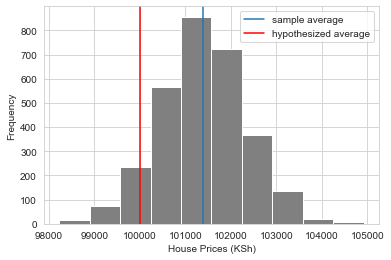

In [18]:
plt.hist(bootstrap_sample, color='grey')
plt.axvline([bootstrap_sample_mean], label='sample average')
plt.axvline([hypothesized_price], 
            label='hypothesized average',
            color='r')
plt.xlabel('House Prices (KSh)')
plt.ylabel('Frequency')
plt.legend()
plt.show()

### Standardization

Before performing a hypothesis test, we need to standardize the rental price values since variables have arbitrary units and ranges. For this hypothesis test, we use the z-score.

$$z = \frac{\text{sample statistics - hypothesized parameter value}}{\text{standard error}}$$

All the values are already present except for the standard error which is calculated by getting the standard deviation of the bootstrap sample. After which, we'll substitute them into the equation. 

- Here, the standard error is about 900. 

In [19]:
std_error = np.std(bootstrap_sample, ddof=1)
std_error

939.1265123154645

- The zscore is 1.49. Is this a big or a small number? Let's look at the p-value.

In [20]:
z_score = (bootstrap_sample_mean - hypothesized_price) / std_error
print(z_score)

1.4684613319873832


## Computing p-Value

p-value quantify how much evidence there is for the acceptance or rejection of the null hypothesis. Since this is a two sided test, we'll use `ztest()` from  `weightstats`. We'll pass our variable and since there is no second sample, we'll pass `None` to the parameter `x2` and the mean value of 100000 to the parameter `value`.

- The `z_test` does not differ so much from the previously calculated `z_score` and now there is a computed `p_value`. 

In [21]:
z_test, p_value = stests.ztest(rental_aprt.rental_price, 
                               x2=None, 
                               value=100000)
print(f'''z_test: {z_test}, 
p_value: {p_value}''')

z_test: 1.465575201031459, 
p_value: 0.14276405137026352


Alternatively, we can compute the p-value using `norm.cdf()`. 

- Note that with this formula p-value is calculated from the assumption that the test statistics lies in either tail. Therefore, we compute the sum of one value in the negative side and one value in the right tail

In [22]:
p_value1 = norm.cdf(-z_score) + (1 - norm.cdf(z_score))
p_value1

0.14197895233870744

- The second method is also applicable. There is a neglegable difference in the p-value calculated 

In [23]:
p_value2 = 2 * (1 - norm.cdf(z_score))

print(p_value1, p_value2)

0.14197895233870744 0.1419789523387074


## Making Decision

The p-value is less than the alpha value. Therefore, we reject the null hypothesis. 

- Keep in mind that this result could be a false positive (Type I) error. That is, chosing $H_A$ when $H_0$ could be the right choice.

In [24]:
if p_value < alpha:
    print('Reject null hypothesis')
else:
    print('Accept null hypothesis')

Accept null hypothesis


### Computing the Confidence Interval

Due to sampling variability, sample statistics are bound to be wrong by some amount. Here, the hypothesized value for rental prices is 100K while the calculated was 101K, so it is goo to state the confidence interval. Being that an $\alpha$ of 0.2 was used, the confidence interval of $1 - \alpha$ will be 80%. 

- With an 80% CI, the average rental prices is between KSh 100,213 and KSh 102,547. Therefore, since KSh 101K is included in the 80% CI and we had already accepted $H_0$ due to the large p-value, the confidence interval agrees with the outcome. Thus confirming that indeed there was no Type I error violation.

In [25]:
lower = np.quantile(bootstrap_sample, 0.1)
upper = np.quantile(bootstrap_sample, 0.9)

lower, upper

(100179.32526501767, 102556.8578327444)

$$.... \text{ Next Task } ....$$

# **Proportions** 

Suppose that under null hypothesis we assume that 65% of the bedrooms are over 2.

$$H_0: \text{Proportion of bedrooms over 2 = 0.65}$$

$$H_1: \text{Proportion of bedrooms over 2} \leq 0.65$$

- If we check the proportion sample proportion we can see that almost 60% of the bedrooms are over 2. But is this proportion difference between the hypothesized and sample proportions significant?

In [26]:
rental_aprt.bed_cat.value_counts(normalize=True)

over 2        0.594229
at least 2    0.405771
Name: bed_cat, dtype: float64

Setting an alpha of 0.01, we can use equation below to calculate the z-score:

$$z = \frac{\hat{p} - p_0}{\sqrt{\frac{p_0 * (1 - p_0)}{n}}}$$

In [27]:
rental_aprt.bed_cat.value_counts()

over 2        1009
at least 2     689
Name: bed_cat, dtype: int64

- To calculate the z-score, we'll use the variables defined below and then insert them to the equation. `p_hat` which implies the sample proportion is 0.5942 while `p_0` which is the hypothesized proportion is 0.65. `n` is the number of entries in the dataset.

In [28]:
p_hat = rental_aprt.bed_cat.value_counts(normalize=True)[0]
p_0 = 0.65
alpha = 0.01
n = len(rental_aprt)

- The z-score is 4.8183. However, is this a significant score?

In [29]:
numerator = p_hat - p_0
denominator = np.sqrt((p_0 * (1 - p_0)) / n)
z_beds = numerator / denominator
z_beds

-4.8182622646538205

- Being that this is a left-tailed test, we'll transform the z-score using `norm.cdf()`

In [30]:
p_value = norm.cdf(z_beds)
print(p_value)

if p_value <= alpha:
    print('reject null hypothesis')
else:
    print('accept null hypothesis')

7.240696950199298e-07
reject null hypothesis


$\checkmark$ Therefore, the conclusion is that there is a significant difference in sample proportion and hypothesized proportion of bedrooms.

# **Two-Sample t-Test**

In the previous section, the data was analyzed collectively. Here, the data will be analyzed based on regions. Dagoretti North and Westlands have entries above 600 while the rest have entries below 100. Therefore, the first analysis will focus on these two regions while the second analysis on the remaining regions. 

- Below is a plot showing the frequency of houses in these regions

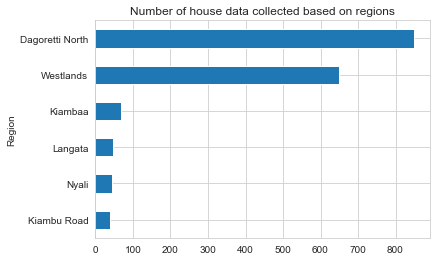

In [31]:
rental_aprt.region\
        .value_counts(ascending=True)\
        .plot(kind='barh', 
              title='Number of house data collected based on regions',
              xlabel='Region')
plt.show()

## Question and Hypotheses

Therefore, the question is:

- "*Are rental prices in Dagoretti North equal to rental prices in Westlands?*"

The null hypothesis is that the overall rental prices is equal in both location, while the alternative hypotheis is that rental price in Dagoretti North is not equal to those in Westlands.

$$H_0: \mu_{\text{Dagoretti North}} - \mu_{\text{Westlands}} = 0$$

$$H_A: \mu_{\text{Dagoretti North}} - \mu_{\text{Westlands}} \neq 0$$

## Our Data

- Before going further, we'll have to subset the data to get data for Dagoretti North and Westlands. 

In [32]:
west_dago = rental_aprt[(rental_aprt.region=='Westlands')\
                        | (rental_aprt.region == 'Dagoretti North')]

westland = west_dago[west_dago.region == 'Westlands'].rental_price
dagoretti = west_dago[west_dago.region == 'Dagoretti North'].rental_price

print(west_dago.head())

            region  rental_price  sq_mtrs  Bedrooms  Bathrooms     bed_cat  \
0        Westlands        155000      4.0       4.0        4.0      over 2   
1  Dagoretti North        100000    300.0       3.0        4.0      over 2   
2  Dagoretti North         75000      3.0       3.0        5.0      over 2   
3  Dagoretti North        135000    227.0       3.0        4.0      over 2   
5        Westlands        150000      2.0       2.0        2.0  at least 2   

     bath_cat  
0      over 3  
1      over 3  
2      over 3  
3      over 3  
5  at least 3  


## Distribution of Variables

- A check for normality reveals that rental prices in Westlands follows a normal distribution while in Dagoretti North the distribution is a slightly skewed to the right. 

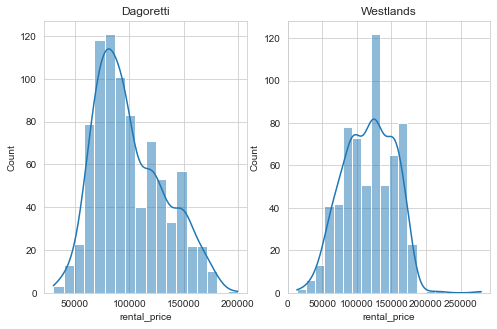

In [33]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 5))
with sns.axes_style('ticks'):
    sns.histplot(dagoretti, kde=True, ax=ax1)
    sns.histplot(westland, kde=True, ax=ax2)
ax1.set_title('Dagoretti')
ax2.set_title('Westlands');

## Levene's Test

For now a t-test will be conducted for both variables. Any adjustment will be made later on. As before, the significance level is set at 0.1 The Levene's test tests the null hypothesis that all input samples are from population with equal variance. Here the p-value is less than 0.05 thus we reject the null hypothesis and conclude that the samples comes from population with significant difference in population variance. 

- Being that the p-value of Levene's Test is quite sensitive to sample size, the test is only used for guidance.

In [34]:
levene(dagoretti, westland, 
       center='mean', 
       proportiontocut=0.05)

LeveneResult(statistic=16.011414974093732, pvalue=6.60369888945088e-05)

## Summary Statistics

The summary statistics shows that the average rental prices in Dagoretti North is about 100K while in Westlands it is about 116K. The question is whether this difference is statistically significant or is it as a result of sampling variability.

In [35]:
west_dago.groupby('region')['rental_price'].mean().dropna()

region
Dagoretti North    100124.705882
Westlands          116943.835385
Name: rental_price, dtype: float64

## Calculating Test Statistics and p-Value

Assuming that null hypothesis is true, $t$ is given by the equation: 

$$t = \frac{(\bar{x}_{\text{Dago}} - \bar{x}_{\text{Westy}})}{\sqrt{\frac{s^2_{\text{Dago}}}{n_{\text{Dago}}} + \frac{s^2_{\text{Westy}}}{n_{\text{Westy}}}}}$$

Being that this is a two sided t-test, we'll use the `pingouin` package to calculate the t statistics and other results. Note that this is an independent test thus the `paired` argument is set to `False` which is the default. Note that the sample sizes are unequal and we've set `correction=True`. This way, the `Welch–Satterthwaite` equation is used to approximate the adjusted degrees of freedom.

$$v = \frac{\left(\frac{s^2_x}{n_x} + \frac{s^2_y}{n_y}\right)^2}{\frac{\left(\frac{s^2_x}{n_x}\right)^2}{\left(n_x - 1\right)} + \frac{\left(\frac{s^2_y}{n_y}\right)^2}{\left(n_y - 1\right)}}$$

- With a p-value less than 0.01, we reject the null hypothesis and conclude that there is a significant difference in rental prices in Dagoretti North and Westlands.

In [36]:
t_test_results = pingouin.ttest(x=dagoretti, 
                                y=westland, 
                                alternative='two-sided',
                                paired=False,
                                confidence=0.80, 
                                correction=True)
print(t_test_results)

               T          dof alternative         p-val  \
T-test -9.385469  1297.012572   two-sided  2.707531e-20   

                                           CI80%   cohen-d       BF10  power  
T-test  [-19116.89069225623, -14521.36831226868]  0.497431  1.581e+17    1.0  


- Alternatively, we can use `ttest_ind()` from `scipy.stats` to get similar results.

In [37]:
from scipy import stats
stats.ttest_ind(dagoretti, westland, equal_var=False)

Ttest_indResult(statistic=-9.385468652722123, pvalue=2.7075312062428993e-20)

# **One Way ANOVA**

The dataset has Kiambaa, Langata, Nyali, and Kiambu Road regions below 100 data entries. Therefore, with only these entries, assuming the variance among them is equal, analysis is done separately. 

- First, let's get a visual representation of the number of house data collected based on regions to confirm this distribution.

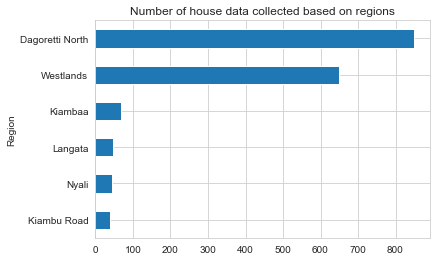

In [38]:
rental_aprt.region\
        .value_counts(ascending=True)\
        .plot(kind='barh', 
              title='Number of house data collected based on regions',
              xlabel='Region')
plt.show()

## Our Data

- Before going further, let's extract the data for the remaining four regions that was not analyzed earlier.

In [39]:
other_regions = rental_aprt[~(rental_aprt.region=='Westlands') &\
                            ~(rental_aprt.region == 'Dagoretti North')]

print(other_regions.sample(5, random_state=35))

      region  rental_price  sq_mtrs  Bedrooms  Bathrooms     bed_cat  \
166    Nyali         40000   2500.0       3.0        3.0      over 2   
186  Kiambaa         40000   2024.0       3.0        2.0      over 2   
235  Langata         45000      3.0       3.0        2.0      over 2   
381    Nyali         60000   2500.0       3.0        2.0      over 2   
204  Kiambaa         45000  20235.0       2.0        2.0  at least 2   

       bath_cat  
166  at least 3  
186  at least 3  
235  at least 3  
381  at least 3  
204  at least 3  


## Question and Hypothesis

The question for analysis of variance will be: 

$$\text{Question: Is the average rental price for these four regions different from each other?}$$

$$H_0: μ_1 = μ_2 = μ_3 = … = μ_k \text{(the means of all the population are equal)}$$

$$H_A: \text{There will be at least one population mean that differs from the rest}$$

## Visualizing the Rental Price Distribution

First things first, we'll have a visual representation of the distribution of rental prices in these regions using a boxplot. 

- According to the boxplots, the distribution of rental prices in Nyali and Langata are higher than the distribution of rental prices in Kiambaa and Kiambu Road. However, the question is, *How significant are these differences?*

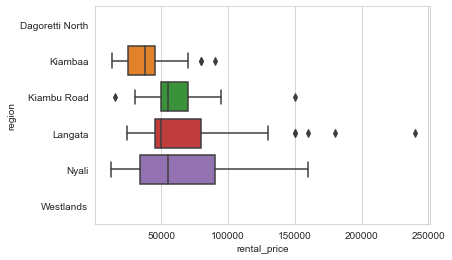

In [40]:
sns.boxplot(data=other_regions.dropna(), 
            x='rental_price',
            y='region')
plt.show()

## General Difference

- Here, the significance level is set at 0.1.

In [41]:
alpha = 0.1

- Then we use `pinguoin.anova()` to compare the values across multiple groups. 

In [42]:
anova_results = pingouin.anova(data=other_regions, 
               dv='rental_price', 
               between='region')
print(anova_results)
print()

if anova_results['p-unc'][0] < alpha:
    print('reject null hypothesis')
else:
    print('accept null hypothesis')

   Source  ddof1  ddof2         F         p-unc       np2
0  region      3    194  13.33395  5.981584e-08  0.170947

reject null hypothesis


$\checkmark$ The p-value $5.98\times 10^{-8}$ is less than the significance value of 0.1 thus null hypothesis of these regions having similar rental prices is rejected. Conclusion can thus be made that at least two of these regions have significant difference between their rental prices. However, this doesn't tell us these two categories.

## Pairwise Difference Test

To identify regions which are different we compare all the four regions, testing each pair in turn. In other words, performing a total of eight tests. 

- To do this in one go, the appropriate method will be using `pingouin`s `.pairwise_ttest()`, setting the argument `p-adjust` to `'bonf'`. This is because if we run one test, the chances of false positive is 10%. With more groups, it's almost guaranteed that there will at least one false positive. 

    - The Bonferroni correction is an adjustment that increase the p-values thus reducing the chances of false positive. 

In [43]:
pairwise_anova = pingouin.pairwise_ttests(data=other_regions, 
                                          dv='rental_price',
                                          between='region', 
                                          padjust='bonf')
print(pairwise_anova)

  Contrast            A            B  Paired  Parametric         T        dof  \
0   region        Nyali      Kiambaa   False        True  4.525915  54.350010   
1   region        Nyali  Kiambu Road   False        True  0.433870  71.369921   
2   region        Nyali      Langata   False        True -0.922508  86.868464   
3   region      Kiambaa  Kiambu Road   False        True -5.901220  62.998660   
4   region      Kiambaa      Langata   False        True -4.949846  54.228669   
5   region  Kiambu Road      Langata   False        True -1.435590  68.326814   

  alternative         p-unc        p-corr p-adjust       BF10    hedges  
0   two-sided  3.315742e-05  1.989445e-04     bonf   1172.002  1.005280  
1   two-sided  6.656917e-01  1.000000e+00     bonf      0.249  0.091828  
2   two-sided  3.588188e-01  1.000000e+00     bonf       0.32 -0.190466  
3   two-sided  1.561818e-07  9.370907e-07     bonf  2.436e+05 -1.269260  
4   two-sided  7.594881e-06  4.556929e-05     bonf   5813.558 

Looking at the uncorrected p-values (`p-unc`) and corrected p-values (`p-corr`) the number of pairs with significant difference remains the same. These significant difference are between: `Kiambaa and Nyali`, `Kiambaa and Kiambu Road`, and `Kiambaa and Langata`.

## Confirming Results

- The results shouldn't be surprising because from the average price in Kiambaa is about 36K while the average rental prices in other regions were between 60K to 72K

In [44]:
other_regions.groupby('region')\
        ['rental_price']\
        .mean()\
        .dropna()


region
Kiambaa        36904.411765
Kiambu Road    60500.000000
Langata        71276.595745
Nyali          63318.181818
Name: rental_price, dtype: float64

In [45]:
aiion

NameError: name 'aiion' is not defined

What's the correlation between rental price and the house square metric

In [ ]:
correlations = rental_aprt.corr()
sns.heatmap(correlations, annot=True)
plt.show()

In [ ]:

sns.regplot(data=a, x='sq_mtrs', y='rental_price', ci=None)

In [ ]:
centering = lambda x: x - x.mean()
a = rental_aprt.drop('region', axis=1).apply(centering)

In [ ]:
a

## Question

The first question is 

In [ ]:
rental_aprt.groupby('region')['rental_price']\
        .mean()\
        .sort_values().plot(kind='barh',
                            title='Average House Rent Price per Region')
plt.xlabel('Average price (KSh)')
plt.show()

In [ ]:
hist_dist('Westlands', 'rental_price', 'hist')